In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import dense_diff_pool
from torch import Tensor
from typing import Tuple

from torch_geometric.utils import to_networkx, negative_sampling
import networkx as nx

In [4]:
import utils.torchUtils as gnn
from utils.torchUtils.cpp_geometric import layers

In [5]:
dout='autoencoder'

In [6]:
gnn.config.set_gpu(False)

In [7]:
torch.Tensor().size

<function Tensor.size>

In [ ]:
from torch_scatter import scatter_max
from torch_geometric.data import Batch

class EdgeMasked(gnn.BaseTransform):
    def __call__(self, data : Data) -> Data:
        edge_mask = data.get('edge_mask', None)
        if edge_mask is None: return data
        return gnn.mask_graph_edges(data, edge_mask)

def sample_pair(data, pair):
    pair = pair.reshape(2,1)
    data.pair_index = pair

    pair_mask = (data.edge_index == pair).all(dim=0)
    data.pair_y = data.edge_y[pair_mask]

    edge_mask = (data.edge_index[:,None] == pair).any(dim=1).any(dim=0)
    if hasattr(data, 'edge_mask'):
        edge_mask = data.edge_mask & edge_mask
    return edge_mask

class PredictPair(gnn.BaseTransform):
    def __call__(self, data : Data) -> Data:
        remove_self = data.edge_index[0] != data.edge_index[1]
        pos_edges = torch.where(remove_self & (data.edge_y == 1))[0]
        neg_edges = torch.where(remove_self & (data.edge_y == 0))[0]
        if pos_edges.shape[0] == 0: pos_edges = neg_edges

        edges = [pos_edges, neg_edges][ torch.randint(2, (1,)) ]
        edge = edges[ torch.randint(edges.shape[0], (1,)) ]
        pair = data.edge_index[:, edge]
        data.edge_mask = sample_pair(data, pair)
        return data

: 

In [64]:
import utils.torchUtils as gnn 

# min_edge = gnn.min_edge_neighbor(n_neighbor=2, function=lambda f:f**2)
min_edge = gnn.min_edge_neighbor(n_neighbor=2, undirected=True)
transform = gnn.Transform(min_edge)
template = gnn.Dataset('../data/template',make_template=True, transform=transform)

def load_training(fn='../data/MX_1200_MY_500-training', template=None):
    transform = template.transform + PredictPair()
    dataset = gnn.Dataset(fn,transform=transform)[:9000]
    training, validation = gnn.train_test_split(dataset, 0.2)
    # training, validation = dataset[1800:], dataset[:1800]

    batch_size = 100
    trainloader = DataLoader(training, batch_size=batch_size, num_workers=gnn.config.ncpu)
    validloader = DataLoader(validation, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return trainloader, validloader

trainloader, validloader  = load_training(template=template)

In [105]:
loss='mismatched_bjet_loss'
# loss='std_loss'
model = gnn.modelMap['golden_pair'](dataset=template, loss=loss)

In [106]:
for batch in trainloader: pass

In [107]:
from pytorch_lightning import Trainer

trainer = Trainer(max_epochs=10, gpus=1*gnn.config.ngpu)
trainer.fit(model, trainloader, validloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name    | Type          | Params
-------------------------------------------
0  | embed_1 | GCNLinear     | 768   
1  | conv_1  | GCNConvMask   | 12.4 K
2  | norm_1  | GCNBatchNorm  | 256   
3  | relu_1  | GCNRelu       | 0     
4  | embed_2 | GCNLinear     | 16.6 K
5  | conv_2  | GCNConvMask   | 49.3 K
6  | norm_2  | GCNBatchNorm  | 512   
7  | relu_2  | GCNRelu       | 0     
8  | pair_1  | PairPredictor | 24.7 K
9  | relu_3  | ReLU          | 0     
10 | readout | Sequential    | 3.2 K 
-------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 90/90 [00:18<00:00,  4.74it/s, loss=1.67, v_num=10]


In [150]:
class predict_data(gnn.BaseTransform):
    def __init__(self, model=model):
        super().__init__()
        self.model = model
    def __call__(self, data : Data) -> Data:
        pairs = torch.LongTensor([ [i,j] for i in range(data.num_nodes) for j in range(i+1, data.num_nodes)])
        edge_mask = data.edge_mask.clone()
        def predict_pair(pair, edge_mask=edge_mask):
            data.edge_mask = edge_mask
            data.edge_mask = sample_pair(data, pair)
            return model.predict(data)
        edge_o = torch.Tensor([predict_pair(pair) for pair in pairs])
        min_o, max_o = edge_o.min(), edge_o.max()
        data.edge_o = (edge_o-min_o)/(max_o+min_o)
        data.rank_o = data.edge_o.argsort(descending=True).argsort()
        return data

def load_testing(fn='../data/MX_1200_MY_500-testing', template=None):
    transform = template.transform + predict_data() + gnn.to_uptri_graph()
    sample = gnn.Dataset(fn, transform=transform)[:1000]
    batch_size = 100
    testloader = DataLoader(sample, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return testloader
testloader = load_testing(template=template)

In [158]:
data = next( data for data in testloader.dataset if data.y.sum() == 8 and data.num_nodes == 10)

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:>)

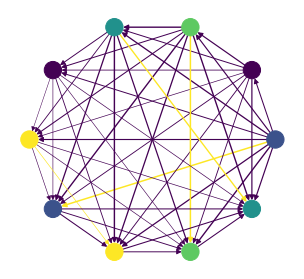

In [159]:
gnn.draw_data(data, width=data.edge_o+0.5, edge_color=data.edge_y)

(<Figure size 384x360 with 2 Axes>, <AxesSubplot:ylabel='N Edges'>)

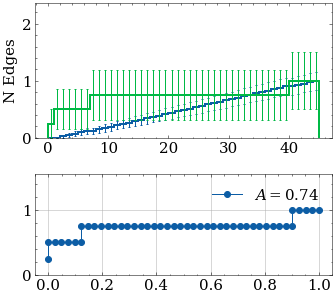

In [166]:
hist_multi(
    [data.rank_o[data.edge_y == 0],data.rank_o[data.edge_y == 1]], ylabel='N Edges',
    cumulative=1, correlation=True,
)